# Dataset Preparation Playground
The aim of this notebook is to prepare the data in such a way that it can later be loaded up and used in a convolutional network efficiently. The end result is storing and loading a .tfrecord file, also processing the images such that the resulting size is the same for all examples.

Sources used mostly:
* http://warmspringwinds.github.io/tensorflow/tf-slim/2016/12/21/tfrecords-guide/

## Simple Reconstruction
Serialization and desertialization of one image, converting it into byte (string) representation.

True

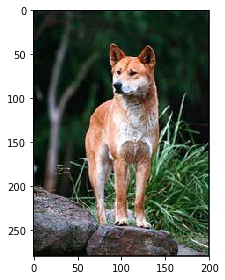

In [1]:
%matplotlib inline

import numpy as np
import skimage.io as io

dog_img = io.imread("../data/train/00a338a92e4e7bf543340dc849230e75.jpg")
io.imshow(dog_img)

dog_string = dog_img.tostring()
reconstructed_dog_1d = np.fromstring(dog_string, dtype=np.uint8)
reconstructed_dog_img = reconstructed_dog_1d.reshape(dog_img.shape)
np.allclose(dog_img, reconstructed_dog_img)

## TFRecord
Serialization and deserialization of several images into one TFRecord object

In [94]:
%matplotlib inline
import numpy as np
import skimage.io as io
import tensorflow as tf

def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))


dog_dict = {
    "dingo": np.array([1, 0, 0]),
    "german_shepherd": np.array([0, 1, 0]),
    "kuvasz": np.array([0, 0, 1])
}

# Get some image/annotation pairs for example 
filename_pairs = [
    ("../data/train/00a338a92e4e7bf543340dc849230e75.jpg", dog_dict["dingo"]),
    ("../data/train/0ac12e1849fd51b2158d16b8f5e75551.jpg", dog_dict["german_shepherd"]),
    ("../data/train/0a0c223352985ec154fd604d7ddceabd.jpg", dog_dict["kuvasz"])
]


tfrecords_filename = 'arbitrary_doggos.tfrecords'

writer = tf.python_io.TFRecordWriter(tfrecords_filename)

# original images for comparison
original_images = []

for img_path, target in filename_pairs:
    img = io.imread(img_path)
    height = img.shape[0]
    width = img.shape[1]
    target_size = target.shape[0]
    
    original_images.append((img, target))
    img_raw = img.tostring()
    target_raw = target.tostring()
    
    example = tf.train.Example(features=tf.train.Features(feature={
        'height': _int64_feature(height),
        'width': _int64_feature(width),
        'image_raw': _bytes_feature(img_raw),
        'target_size': _int64_feature(target_size),
        'target_raw': _bytes_feature(target_raw)
    }))
    
    writer.write(example.SerializeToString())
    
writer.close()

In [120]:
reconstructed_images = []
record_iterator = tf.python_io.tf_record_iterator(path=tfrecords_filename)

for string_record in record_iterator:
    example = tf.train.Example()
    example.ParseFromString(string_record)
    
    height = int(example.features.feature['height']
                                 .int64_list
                                 .value[0])
    
    width = int(example.features.feature['width']
                                .int64_list
                                .value[0])
    
    img_string = (example.features.feature['image_raw']
                                  .bytes_list
                                  .value[0])
    
    taret_size = (example.features.feature['target_size']
                                  .int64_list
                                  .value[0])
    
    target_string = (example.features.feature['target_raw']
                                .bytes_list
                                .value[0])
    
    img_1d = np.fromstring(img_string, dtype=np.uint8)
    reconstructed_img = img_1d.reshape((height, width, -1))
    
    target_1d = np.fromstring(target_string, dtype=np.int64)
    
    # Targets don't have depth (3rd dimension)
    reconstructed_target = target_1d.reshape((target_size, ))
    reconstructed_images.append((reconstructed_img, reconstructed_target))
    

In [121]:
# Let's check if the reconstructed images match
# the original images

for original_pair, reconstructed_pair in zip(original_images, reconstructed_images):
    img_pair_to_compare, target_pair_to_compare = zip(original_pair, reconstructed_pair)
    print(np.allclose(*img_pair_to_compare))
    print(np.allclose(*target_pair_to_compare))


True
True
True
True
True
True


## Batch Resize
For the next step I thought I needed a dataset of images, of equal size. I have roughly resized the images I have, so that I have something to work with. Ultimately, the batching section will actually resize the images for me using ```tf.image.resize_image_with_crop_or_pad```

In [51]:
from os import listdir
import numpy as np

# Ignore warnings from sklearn
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import skimage.io as io
import skimage.transform as tr

%matplotlib inline

IMAGE_HEIGHT = 384
IMAGE_WIDTH = 384
src_dir = "../data/train"
dest_dir = "../data/train_rough"

min_height = 1e8
min_width = 1e8

img_fnames = listdir(src_dir)
for i in range(5):
    print(img_fnames[i])


1ef5e8db93701b28e1203ecd7e1baf37.jpg
3eaedbc5f02f78673b57ef47d9f1115d.jpg
aa52399aa598792ef63fe14828660bc3.jpg
05a05cf4c8d6a4f3f780a9112a11999b.jpg
04cce0cd53c6f01d242a49e43de513a1.jpg


In [52]:
# Rescale image to set size
total = len(img_fnames)
for i, img_fname in enumerate(img_fnames):
    img_true = io.imread(src_dir + "/" + img_fname)
    img_res = tr.resize(img_true, (IMAGE_WIDTH, IMAGE_HEIGHT))
    io.imsave(dest_dir + "/" + img_fname, img_res)
    if (i % 1000 == 0):
        print("Processed images: %d / %d " %(i, total))

Processed images: 0 / 10222 
Processed images: 100 / 10222 
Processed images: 200 / 10222 
Processed images: 300 / 10222 
Processed images: 400 / 10222 
Processed images: 500 / 10222 
Processed images: 600 / 10222 
Processed images: 700 / 10222 
Processed images: 800 / 10222 
Processed images: 900 / 10222 
Processed images: 1000 / 10222 
Processed images: 1100 / 10222 
Processed images: 1200 / 10222 
Processed images: 1300 / 10222 
Processed images: 1400 / 10222 
Processed images: 1500 / 10222 
Processed images: 1600 / 10222 
Processed images: 1700 / 10222 
Processed images: 1800 / 10222 
Processed images: 1900 / 10222 
Processed images: 2000 / 10222 
Processed images: 2100 / 10222 
Processed images: 2200 / 10222 
Processed images: 2300 / 10222 
Processed images: 2400 / 10222 
Processed images: 2500 / 10222 
Processed images: 2600 / 10222 
Processed images: 2700 / 10222 
Processed images: 2800 / 10222 
Processed images: 2900 / 10222 
Processed images: 3000 / 10222 
Processed images: 31

## Read CSV
I shall need to read a CSV file to obtain the targets. I should be abe to obtain a list of (image_name, breed_name) combinations. That should be transformed into one-hot encoding, for learning.

In [2]:
import numpy as np

csv_src = "../data/labels.csv"

my_data = np.genfromtxt(csv_src, delimiter=',', dtype="|S32")[1:]
print(my_data)

all_breeds = set(my_data[:, 1])
all_breeds_dict = {breed: i for i, breed in enumerate(all_breeds)}
print("Number of breeds:", len(all_breeds_dict))
print("Breeds:\n", all_breeds_dict)

def one_hot(y_type, all_types_dict):
    res = np.array([0] * len(all_types_dict))
    res[all_types_dict[y_type]] = 1
    return res

print(one_hot(b"newfoundland", all_breeds_dict))
    

[[b'000bec180eb18c7604dcecc8fe0dba07' b'boston_bull']
 [b'001513dfcb2ffafc82cccf4d8bbaba97' b'dingo']
 [b'001cdf01b096e06d78e9e5112d419397' b'pekinese']
 ..., 
 [b'ffe2ca6c940cddfee68fa3cc6c63213f' b'airedale']
 [b'ffe5f6d8e2bff356e9482a80a6e29aac' b'miniature_pinscher']
 [b'fff43b07992508bc822f33d8ffd902ae' b'chesapeake_bay_retriever']]
Number of breeds: 120
Breeds:
 {b'chow': 98, b'irish_water_spaniel': 0, b'german_short-haired_pointer': 114, b'standard_poodle': 2, b'pug': 3, b'miniature_schnauzer': 5, b'kelpie': 6, b'american_staffordshire_terrier': 7, b'black-and-tan_coonhound': 64, b'great_dane': 8, b'giant_schnauzer': 30, b'sealyham_terrier': 9, b'eskimo_dog': 65, b'brittany_spaniel': 66, b'west_highland_white_terrier': 112, b'groenendael': 10, b'weimaraner': 11, b'ibizan_hound': 13, b'cairn': 14, b'lakeland_terrier': 15, b'rottweiler': 16, b'irish_terrier': 96, b'curly-coated_retriever': 93, b'cardigan': 17, b'basenji': 67, b'soft-coated_wheaten_terrier': 68, b'boxer': 69, b'whi

## Batching and reading images in a graph
The images will be read inside a Tensorflow graph, and will be put into a batch.

In [3]:
%matplotlib inline

import tensorflow as tf
import skimage.io as io

IMAGE_HEIGHT = 384
IMAGE_WIDTH = 384
TARGET_SIZE = 3  # number of dog breeds

tfrecords_filename = 'arbitrary_doggos.tfrecords'

def read_and_decode(filename_queue):
    reader = tf.TFRecordReader()
    _, serialized_example = reader.read(filename_queue)

    features = tf.parse_single_example(
      serialized_example,
      # Defaults are not specified since both keys are required.
      features={
        'height': tf.FixedLenFeature([], tf.int64),
        'width': tf.FixedLenFeature([], tf.int64),
        'image_raw': tf.FixedLenFeature([], tf.string),
        'target_size': tf.FixedLenFeature([], tf.int64),
        'target_raw': tf.FixedLenFeature([], tf.string)
        })

    # Convert from a scalar string tensor (whose single string has
    # length mnist.IMAGE_PIXELS) to a uint8 tensor with shape
    # [mnist.IMAGE_PIXELS].
    image = tf.decode_raw(features['image_raw'], tf.uint8)
    target = tf.decode_raw(features['target_raw'], tf.int64)
    
    height = tf.cast(features['height'], tf.int32)
    width = tf.cast(features['width'], tf.int32)
    target_size = tf.cast(features['target_size'], tf.int32)
    
    image_shape = tf.stack([height, width, 3])
    target_shape = tf.stack([target_size, 1])
    
    image = tf.reshape(image, image_shape)
    target = tf.reshape(target, target_shape)
    
    image_size_const = tf.constant((IMAGE_HEIGHT, IMAGE_WIDTH, 3), dtype=tf.int32)
    target_size_const = tf.constant((TARGET_SIZE, 1), dtype=tf.int32)
    
    # Random transformations can be put here: right before you crop images
    # to predefined size. To get more information look at the stackoverflow
    # question linked above.
    
    resized_image = tf.image.resize_image_with_crop_or_pad(image=image,
                                           target_height=IMAGE_HEIGHT,
                                           target_width=IMAGE_WIDTH)    
    
    resized_target = tf.reshape(tensor=target, shape=target_size_const)
    
    images, targets = tf.train.shuffle_batch( [resized_image, resized_target],
                                               batch_size=2,
                                               capacity=30,
                                               num_threads=2,
                                               min_after_dequeue=10,
                                               allow_smaller_final_batch=True)
    
    return images, targets

(384, 384, 3)


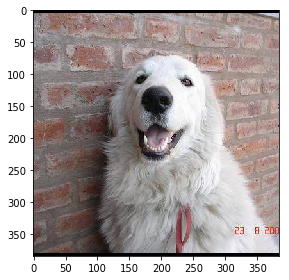

[[0]
 [0]
 [1]]


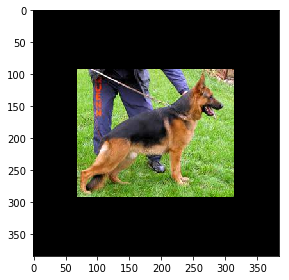

[[0]
 [1]
 [0]]
--- --- --- --- ---
(384, 384, 3)


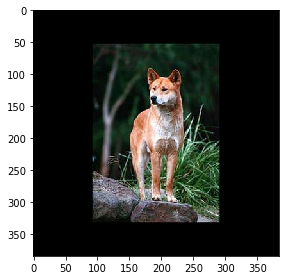

[[1]
 [0]
 [0]]


IndexError: index 1 is out of bounds for axis 0 with size 1

In [9]:
filename_queue = tf.train.string_input_producer(
    [tfrecords_filename], num_epochs=10)

# Even when reading in multiple threads, share the filename
# queue.
image, target = read_and_decode(filename_queue)

# The op for initializing the variables.
init_op = tf.group(tf.global_variables_initializer(),
                   tf.local_variables_initializer())

with tf.Session() as sess:
    sess.run(init_op)
    
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)
    
    # Let's read off 3 batches just for example
    for i in range(3):
        img, targ = sess.run([image, target])
        print(img[0, :, :, :].shape)
        
        # We selected the batch size of two
        # So we should get two image pairs in each batch
        # Let's make sure it is random

        io.imshow(img[0, :, :, :])
        io.show()

        print(targ[0])
        
        io.imshow(img[1, :, :, :])
        io.show()

        print(targ[1])
        
        print ("--- --- --- --- ---")
    
    coord.request_stop()
    coord.join(threads)